# Gentrification Degree Index (GDI) for Paris (2013-2021)

## Version 4.0 - Comprehensive Methodology Implementation

**Research Context**: Analyzing gentrification patterns in Paris intra-muros using a theoretically-grounded composite index.

**Methodology**: Following the academic framework for measuring gentrification through multi-dimensional socio-economic indicators at IRIS level.

**Time Period**: 2013, 2017, 2021 (three observation points)

**Spatial Unit**: IRIS (Îlots Regroupés pour l'Information Statistique) - French infra-urban statistical units of ~2,000 inhabitants

---

### Theoretical Background

Gentrification is defined as the socio-spatial transformation of historically working-class urban areas through:
- **Income uplift**: Rising median disposable income
- **Class recomposition**: Influx of professionals/executives, displacement of manual workers
- **Demographic shifts**: Young professionals (25-39) replacing elderly populations
- **Economic profile change**: Shift from welfare/pension to labor income sources

This notebook implements the GDI formula:

$$GDI_{i,t} = \frac{1}{N}(Z_{medinc}^{(t)} + Z_{CS3}^{(t)} - Z_{CS6}^{(t)} + Z_{25-39}^{(t)} - Z_{65+}^{(t)} + Z_{labor}^{(t)} - Z_{pens}^{(t)} - Z_{social}^{(t)})$$

Where:
- $Z$ = year-specific standardized (z-score) values
- $N = 8$ components
- Positive terms indicate gentrification
- Negative terms indicate absence of gentrification

## 1. Setup and Configuration

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Paths
DATA_DIR = Path('outputs/clean_v3')
FIGURES_DIR = Path('outputs/figures_gdi')
TABLES_DIR = Path('outputs/tables_gdi')
MAPS_DIR = Path('outputs/maps_gdi')

# Create directories
for dir_path in [FIGURES_DIR, TABLES_DIR, MAPS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Random seed for reproducibility
np.random.seed(42)

print("✓ Environment configured")
print(f"  Data directory: {DATA_DIR}")
print(f"  Output directories created: {FIGURES_DIR}, {TABLES_DIR}, {MAPS_DIR}")

✓ Environment configured
  Data directory: outputs/clean_v3
  Output directories created: outputs/figures_gdi, outputs/tables_gdi, outputs/maps_gdi


## 2. Data Loading

Load all required datasets for the three observation years: 2013, 2017, 2021

In [75]:
print("Loading datasets...\n")

# FILOSOFI (income data) - 3 years
filosofi_2013 = pd.read_parquet(Path('../datasets') / 'filosofi_2013_paris.parquet')
filosofi_2017 = pd.read_parquet(Path('../datasets') / 'filosofi_2017_paris.parquet')
filosofi_2021 = pd.read_parquet(Path('../datasets') / 'filosofi_2021_paris.parquet')

print(f"FILOSOFI 2013: {filosofi_2013.shape}")
print(f"FILOSOFI 2017: {filosofi_2017.shape}")
print(f"FILOSOFI 2021: {filosofi_2021.shape}")

# CENSUS (demographic/social data) - 3 years
census_2013 = pd.read_parquet(Path('../datasets') / 'census_2013_paris.parquet')
census_2017 = pd.read_parquet(Path('../datasets') / 'census_2017_paris.parquet')
census_2021 = pd.read_parquet(Path('../datasets') / 'census_2021_paris.parquet')

print(f"\nCENSUS 2013: {census_2013.shape}")
print(f"CENSUS 2017: {census_2017.shape}")
print(f"CENSUS 2021: {census_2021.shape}")

# IRIS geographic boundaries (all 992 IRIS)
iris_geo = gpd.read_file(Path('../outputs') / 'iris_paris75.geojson')
print(f"\nIRIS Geography: {iris_geo.shape}")
print(f"  CRS: {iris_geo.crs}")
print(f"  Columns: {list(iris_geo.columns)}")

Loading datasets...

FILOSOFI 2013: (853, 10)
FILOSOFI 2017: (871, 10)
FILOSOFI 2021: (992, 10)

CENSUS 2013: (992, 13)
CENSUS 2017: (992, 13)
CENSUS 2021: (992, 13)

IRIS Geography: (992, 10)
  CRS: EPSG:4326
  Columns: ['dep', 'insee_com', 'nom_com', 'iris', 'code_iris', 'nom_iris', 'typ_iris', 'geo_point_2d', 'id', 'geometry']


In [76]:
# Create IRIS neighborhood grouping by removing trailing numbers
# Example: "Amérique 1", "Amérique 2" -> "Amérique"

def extract_iris_quartier(nom_iris):
    """
    Extract IRIS neighborhood name by removing trailing number.
    Handles both single and multi-digit numbers.
    """
    import re
    # Remove trailing space + digits (e.g., " 1", " 15", " 22")
    return re.sub(r'\s+\d+$', '', str(nom_iris))

# Add quartier column to ALL IRIS (not filtering yet)
iris_geo['quartier_iris'] = iris_geo['nom_iris'].apply(extract_iris_quartier)

print(f"Total IRIS: {len(iris_geo)}")
print(f"IRIS type distribution:")
print(iris_geo['typ_iris'].value_counts())

# Calculate quartier composition statistics for ALL IRIS types
quartier_composition = iris_geo.groupby('quartier_iris')['typ_iris'].value_counts().unstack(fill_value=0)
quartier_composition['total_iris'] = quartier_composition.sum(axis=1)

# Calculate percentages for each IRIS type
for typ in ['H', 'A', 'D', 'Z']:
    if typ in quartier_composition.columns:
        quartier_composition[f'pct_{typ}'] = (quartier_composition[typ] / quartier_composition['total_iris'] * 100)
    else:
        quartier_composition[f'pct_{typ}'] = 0.0

# Classify quartiers based on composition:
# 1. Residential: ≥50% H
# 2. Activity: <50% H AND (A+Z) > D
# 3. Special: <50% H AND D ≥ (A+Z)
def classify_quartier(row):
    pct_H = row.get('pct_H', 0)
    
    if pct_H >= 50:
        return 'Residential'
    else:
        # <50% H
        count_A = row.get('A', 0)
        count_Z = row.get('Z', 0)
        count_D = row.get('D', 0)
        
        if (count_A + count_Z) > count_D:
            return 'Activity'
        else:
            return 'Special'

quartier_composition['quartier_label'] = quartier_composition.apply(classify_quartier, axis=1)

# Assign hatching based on quartier_label
# Grey: Activity, Green: Special, None: Residential
quartier_composition['hatch_type'] = quartier_composition['quartier_label'].map({
    'Residential': None,
    'Activity': 'grey',
    'Special': 'green'
})

print(f"\n{'='*60}")
print("QUARTIER CLASSIFICATION:")
print(f"{'='*60}")
print(f"  Residential (≥50% H):          {(quartier_composition['quartier_label'] == 'Residential').sum()} quartiers")
print(f"  Activity (<50% H, A+Z > D):    {(quartier_composition['quartier_label'] == 'Activity').sum()} quartiers (grey hatched)")
print(f"  Special (<50% H, D ≥ A+Z):     {(quartier_composition['quartier_label'] == 'Special').sum()} quartiers (green hatched)")

# Show detailed composition for non-Residential quartiers
non_residential = quartier_composition[quartier_composition['quartier_label'] != 'Residential']
if len(non_residential) > 0:
    print(f"\n{'='*60}")
    print("NON-RESIDENTIAL QUARTIERS DETAIL:")
    print(f"{'='*60}")
    for quartier, row in non_residential.iterrows():
        print(f"  {quartier:30s} | Label: {row['quartier_label']:12s} | H:{row.get('pct_H',0):5.1f}% A:{row.get('pct_A',0):5.1f}% D:{row.get('pct_D',0):5.1f}% Z:{row.get('pct_Z',0):5.1f}%")

# Create quartier-level geometry by dissolving ALL IRIS geometries
iris_quartiers = iris_geo.dissolve(by='quartier_iris', as_index=False, aggfunc='first')
iris_quartiers = iris_quartiers[['quartier_iris', 'geometry', 'dep', 'nom_com']].copy()

# Add quartier classification information
iris_quartiers = iris_quartiers.merge(
    quartier_composition[['quartier_label', 'hatch_type', 'pct_H', 'pct_A', 'pct_D', 'pct_Z']], 
    left_on='quartier_iris', 
    right_index=True, 
    how='left'
)

print(f"\n✓ Created quartier-level geometries: {len(iris_quartiers)} quartiers (ALL types)")
print(f"  Residential quartiers: {(iris_quartiers['quartier_label'] == 'Residential').sum()}")
print(f"  Activity quartiers (grey hatched): {(iris_quartiers['quartier_label'] == 'Activity').sum()}")
print(f"  Special quartiers (green hatched): {(iris_quartiers['quartier_label'] == 'Special').sum()}")

Total IRIS: 992
IRIS type distribution:
typ_iris
H    861
A     88
D     43
Name: count, dtype: int64

QUARTIER CLASSIFICATION:
  Residential (≥50% H):          73 quartiers
  Activity (<50% H, A+Z > D):    7 quartiers (grey hatched)
  Special (<50% H, D ≥ A+Z):     14 quartiers (green hatched)

NON-RESIDENTIAL QUARTIERS DETAIL:
  Bassin de l'Arsenal            | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Bassin de la Villette          | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Bois de Boulogne               | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Bois de Vincennes              | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Buttes Chaumont                | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Canal Saint-Denis              | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Canal Saint-Martin             | Label: Special      | H:  0.0% A:  0.0% D:100.0% Z:  0.0%
  Champ de Mars   

In [77]:
# Create a mapping from code_iris to quartier_iris for efficient merging (ALL IRIS)
iris_mapping = iris_geo[['code_iris', 'quartier_iris']].drop_duplicates()

# Also add quartier_label to the mapping for filtering later
iris_mapping = iris_mapping.merge(
    quartier_composition[['quartier_label']],
    left_on='quartier_iris',
    right_index=True,
    how='left'
)

print(f"Created mapping: {len(iris_mapping)} code_iris -> quartier_iris entries (ALL IRIS)")
print(f"  Residential quartiers: {(iris_mapping['quartier_label'] == 'Residential').sum()} IRIS")
print(f"  Activity quartiers: {(iris_mapping['quartier_label'] == 'Activity').sum()} IRIS")
print(f"  Special quartiers: {(iris_mapping['quartier_label'] == 'Special').sum()} IRIS")

Created mapping: 992 code_iris -> quartier_iris entries (ALL IRIS)
  Residential quartiers: 912 IRIS
  Activity quartiers: 39 IRIS
  Special quartiers: 41 IRIS


## 3. Data Preparation and Harmonization

### 3.1 Handle Missing Values (INSEE Suppression Codes)

Following INSEE methodology:
- `'ns'` = non significatif (small population <1000, <500 households)
- `'nd'` = non disponible (non-residential zones: parks, industrial)
- `'s'`, `'c'` = secret statistique

In [78]:
def clean_filosofi_data(df, year, iris_mapping):
    """
    Clean FILOSOFI data by converting suppression codes to NaN.
    Adds quartier_iris column using mapping.
    """
    df_clean = df.copy()
    
    # Suppression codes to convert to NaN
    suppression_codes = ['ns', 'nd', 's', 'c', '/', '-', 'NA']
    
    # Identify numeric columns
    numeric_cols = ['median_uc', 'q1_uc', 'q3_uc', 'd9d1_ratio', 'gini',
                    'share_activity_income', 'share_pensions', 'share_social_benefits']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            # Convert suppression codes to NaN
            mask = df_clean[col].isin(suppression_codes)
            df_clean.loc[mask, col] = np.nan
            
            # Convert to numeric
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '.')
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Add quartier_iris via merge with mapping
    df_clean = df_clean.merge(iris_mapping, on='code_iris', how='left')
    
    print(f"FILOSOFI {year}: {len(df_clean)} IRIS, {df_clean[numeric_cols].isna().sum().sum()} total missing values")
    
    return df_clean

# Clean all FILOSOFI datasets
filosofi_2013_clean = clean_filosofi_data(filosofi_2013, 2013, iris_mapping)
filosofi_2017_clean = clean_filosofi_data(filosofi_2017, 2017, iris_mapping)
filosofi_2021_clean = clean_filosofi_data(filosofi_2021, 2021, iris_mapping)

FILOSOFI 2013: 853 IRIS, 0 total missing values
FILOSOFI 2017: 871 IRIS, 8 total missing values
FILOSOFI 2021: 992 IRIS, 1024 total missing values
FILOSOFI 2017: 871 IRIS, 8 total missing values
FILOSOFI 2021: 992 IRIS, 1024 total missing values


### 3.2 Calculate Census-Derived Variables

Transform census counts into percentages for GDI components:
- **CS3 Share**: % of population 15+ who are executives/professionals (cadres)
- **CS6 Share**: % of population 15+ who are manual workers (ouvriers)
- **Age 25-39 Share**: % of total population
- **Age 65+ Share**: % of total population

In [79]:
def calculate_census_shares(df, year, iris_mapping):
    """
    Calculate percentage shares from census counts.
    Adds quartier_iris column using mapping.
    """
    df_shares = df.copy()
    
    # Socio-professional shares (% of active population 15+)
    denom_pop15 = df.get('pop_15plus', df.get('population_15plus', 1))
    if 'pop_cadres' in df.columns and 'pop_ouvriers' in df.columns:
        df_shares['share_cs3'] = (df['pop_cadres'] / denom_pop15 * 100)
        df_shares['share_cs6'] = (df['pop_ouvriers'] / denom_pop15 * 100)
    else:
        df_shares['share_cs3'] = np.nan
        df_shares['share_cs6'] = np.nan

    # Age shares (% of total population)
    denom_tot = df.get('pop_total', df.get('population', 1))
    if 'pop_25_39' in df.columns and 'pop_65plus' in df.columns:
        df_shares['share_25_39'] = (df.get('pop_25_39', 0) / denom_tot * 100)
        df_shares['share_65plus'] = (df.get('pop_65plus', 0) / denom_tot * 100)
    else:
        df_shares['share_25_39'] = np.nan
        df_shares['share_65plus'] = np.nan

    # Add quartier_iris via merge with mapping
    df_shares = df_shares.merge(iris_mapping, on='code_iris', how='left')

    # Helper to safely format means
    def safe_mean(col):
        if col in df_shares.columns and df_shares[col].notna().any():
            return f"{df_shares[col].mean():.1f}%"
        return "N/A"

    print(f"CENSUS {year}: Calculated shares for {len(df_shares)} IRIS")
    print(f"  Mean CS3 (executives): {safe_mean('share_cs3')}")
    print(f"  Mean CS6 (workers):   {safe_mean('share_cs6')}")
    print(f"  Mean Age 25-39:       {safe_mean('share_25_39')}")
    print(f"  Mean Age 65+:         {safe_mean('share_65plus')}")
    
    return df_shares

# Calculate shares for all years
census_2013_shares = calculate_census_shares(census_2013, 2013, iris_mapping)
census_2017_shares = calculate_census_shares(census_2017, 2017, iris_mapping)
census_2021_shares = calculate_census_shares(census_2021, 2021, iris_mapping)

CENSUS 2013: Calculated shares for 992 IRIS
  Mean CS3 (executives): 28.3%
  Mean CS6 (workers):   4.7%
  Mean Age 25-39:       26.1%
  Mean Age 65+:         15.3%
CENSUS 2017: Calculated shares for 992 IRIS
  Mean CS3 (executives): 29.1%
  Mean CS6 (workers):   4.2%
  Mean Age 25-39:       25.6%
  Mean Age 65+:         16.7%
CENSUS 2021: Calculated shares for 992 IRIS
  Mean CS3 (executives): 30.7%
  Mean CS6 (workers):   4.0%
  Mean Age 25-39:       25.6%
  Mean Age 65+:         17.2%


### 3.3 Merge Datasets by Year

Combine FILOSOFI + CENSUS + Geography for each observation year

In [80]:
def aggregate_to_quartier(filosofi_df, census_df, year):
    """
    Aggregate FILOSOFI and CENSUS data from IRIS to quartier level.
    Uses weighted averages where appropriate.
    """
    # Aggregate FILOSOFI - use median of medians for income measures
    filosofi_agg = filosofi_df.groupby('quartier_iris').agg({
        'median_uc': 'median',
        'q1_uc': 'median',
        'q3_uc': 'median',
        'd9d1_ratio': 'median',
        'gini': 'median',
        'share_activity_income': 'mean',
        'share_pensions': 'mean',
        'share_social_benefits': 'mean'
    }).reset_index()
    
    # Aggregate CENSUS - use means for share variables
    census_agg = census_df.groupby('quartier_iris').agg({
        'share_cs3': 'mean',
        'share_cs6': 'mean',
        'share_25_39': 'mean',
        'share_65plus': 'mean'
    }).reset_index()
    
    print(f"Year {year} - Aggregated to quartier level:")
    print(f"  FILOSOFI: {len(filosofi_agg)} quartiers")
    print(f"  CENSUS: {len(census_agg)} quartiers")
    
    return filosofi_agg, census_agg

def merge_year_data_quartier(filosofi_agg, census_agg, iris_quartiers_df, year):
    """
    Merge all data sources for a given year at quartier level.
    """
    # Start with quartier geometry + classification
    merged = iris_quartiers_df[['quartier_iris', 'geometry', 'dep', 'nom_com', 'quartier_label', 'hatch_type']].copy()
    
    # Merge FILOSOFI
    merged = merged.merge(
        filosofi_agg,
        on='quartier_iris',
        how='left'
    )
    
    # Merge CENSUS shares
    merged = merged.merge(
        census_agg,
        on='quartier_iris',
        how='left'
    )
    
    # Add year column
    merged['year'] = year
    
    print(f"Year {year}:")
    print(f"  Total quartiers: {len(merged)}")
    print(f"  Residential: {(merged['quartier_label'] == 'Residential').sum()}")
    print(f"  Activity: {(merged['quartier_label'] == 'Activity').sum()}")
    print(f"  Special: {(merged['quartier_label'] == 'Special').sum()}")
    print(f"  Complete cases (no missing): {merged.dropna().shape[0]}")
    
    return merged

# Aggregate to quartier level for all three years
filosofi_2013_q, census_2013_q = aggregate_to_quartier(filosofi_2013_clean, census_2013_shares, 2013)
filosofi_2017_q, census_2017_q = aggregate_to_quartier(filosofi_2017_clean, census_2017_shares, 2017)
filosofi_2021_q, census_2021_q = aggregate_to_quartier(filosofi_2021_clean, census_2021_shares, 2021)

# Merge data for all three years
data_2013 = merge_year_data_quartier(filosofi_2013_q, census_2013_q, iris_quartiers, 2013)
data_2017 = merge_year_data_quartier(filosofi_2017_q, census_2017_q, iris_quartiers, 2017)
data_2021 = merge_year_data_quartier(filosofi_2021_q, census_2021_q, iris_quartiers, 2021)

Year 2013 - Aggregated to quartier level:
  FILOSOFI: 76 quartiers
  CENSUS: 94 quartiers
Year 2017 - Aggregated to quartier level:
  FILOSOFI: 77 quartiers
  CENSUS: 94 quartiers
Year 2021 - Aggregated to quartier level:
  FILOSOFI: 94 quartiers
  CENSUS: 94 quartiers
Year 2013:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
  Complete cases (no missing): 3
Year 2017:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
  Complete cases (no missing): 4
Year 2021:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
  Complete cases (no missing): 4
Year 2021 - Aggregated to quartier level:
  FILOSOFI: 94 quartiers
  CENSUS: 94 quartiers
Year 2013:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
  Complete cases (no missing): 3
Year 2017:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
  Complete cases (no missing): 4
Year 2021:
  Total quartiers: 94
  Residential: 73
  Activity: 7
  Special: 14
 

## 4. GDI Component Standardization

### Pooled Z-Score Normalization

**Critical Change**: Using **pooled standardization** across all three years (2013, 2017, 2021) to enable valid temporal comparisons.

**Methodology**:
1. **Calculate pooled parameters**: Combine data from all three years to compute a single mean (μ_pooled) and standard deviation (σ_pooled) for each of the 8 GDI components
2. **Apply uniformly**: Use the SAME pooled parameters to standardize all years

**Formula**: $Z = \frac{X - \mu_{pooled}}{\sigma_{pooled}}$

**Why this matters**:
- ✅ **Valid temporal comparisons**: GDI changes reflect real socioeconomic changes, not just shifts in relative ranking within each year
- ✅ **Consistent baseline**: A z-score of 0 means the same thing across all years (equal to the overall 2013-2021 average)
- ✅ **Interpretable trajectories**: An increase in GDI indicates actual gentrification, not just moving up in year-specific rankings

**What we measure**:
- Absolute position relative to the 2013-2021 Paris-wide distribution
- True socioeconomic change over time (gentrification trajectories)
- Evolution of neighborhood characteristics in standardized units


In [81]:
def calculate_pooled_standardization_params(data_2013, data_2017, data_2021):
    """
    Calculate pooled mean and standard deviation across all three years (2013, 2017, 2021).
    This enables valid temporal comparisons by using the same reference distribution.
    
    Parameters:
    -----------
    data_2013, data_2017, data_2021 : pd.DataFrame
        DataFrames for each year containing the raw variables
    
    Returns:
    --------
    dict : Dictionary with keys as z-score column names, values as {'mean': float, 'std': float}
    """
    # Define the 8 GDI components
    components = {
        'z_median_income': 'median_uc',
        'z_cs3': 'share_cs3',
        'z_cs6': 'share_cs6',
        'z_age_25_39': 'share_25_39',
        'z_age_65plus': 'share_65plus',
        'z_labor_income': 'share_activity_income',
        'z_pension_income': 'share_pensions',
        'z_social_benefits': 'share_social_benefits'
    }
    
    pooled_params = {}
    
    print("\n" + "="*60)
    print("CALCULATING POOLED STANDARDIZATION PARAMETERS")
    print("="*60)
    print("Combining data from 2013, 2017, 2021 for each variable")
    print("Using ONLY Residential quartiers across all years")
    print("-"*60)
    
    for z_col, raw_col in components.items():
        # Collect values from all three years (residential quartiers only)
        all_values = []
        
        for year, df in [(2013, data_2013), (2017, data_2017), (2021, data_2021)]:
            if raw_col in df.columns and 'quartier_label' in df.columns:
                residential_mask = df['quartier_label'] == 'Residential'
                values = df.loc[residential_mask, raw_col].dropna()
                all_values.extend(values.tolist())
        
        # Calculate pooled statistics
        if len(all_values) > 0:
            all_values_array = np.array(all_values)
            pooled_mean = all_values_array.mean()
            pooled_std = all_values_array.std()
            
            pooled_params[z_col] = {
                'mean': pooled_mean,
                'std': pooled_std,
                'n': len(all_values)
            }
            
            print(f"{raw_col:30s} → {z_col:20s}")
            print(f"  Pooled μ = {pooled_mean:8.2f}, Pooled σ = {pooled_std:8.2f}, N = {len(all_values)}")
        else:
            print(f"{raw_col:30s} → {z_col:20s} [NO DATA]")
            pooled_params[z_col] = {'mean': np.nan, 'std': np.nan, 'n': 0}
    
    print("="*60)
    print(f"Pooled parameters calculated for {len(pooled_params)} components")
    print("="*60 + "\n")
    
    return pooled_params


def standardize_gdi_components(df, year, pooled_params):
    """
    Calculate z-scores for all 8 GDI components using POOLED standardization parameters.
    This allows valid temporal comparisons across years.
    
    ONLY for Residential quartiers (≥50% H).
    Returns dataframe with original values + z-scores for all quartiers,
    but z-scores are NaN for non-Residential.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data for a specific year
    year : int
        Year identifier for logging
    pooled_params : dict
        Dictionary with pooled mean/std for each component (from calculate_pooled_standardization_params)
    
    Returns:
    --------
    pd.DataFrame : Input dataframe with added z-score columns
    """
    df_std = df.copy()
    
    # Filter to only Residential quartiers for standardization
    residential_mask = df_std['quartier_label'] == 'Residential'
    
    # Define the 8 GDI components
    components = {
        'z_median_income': 'median_uc',
        'z_cs3': 'share_cs3',
        'z_cs6': 'share_cs6',
        'z_age_25_39': 'share_25_39',
        'z_age_65plus': 'share_65plus',
        'z_labor_income': 'share_activity_income',
        'z_pension_income': 'share_pensions',
        'z_social_benefits': 'share_social_benefits'
    }
    
    print(f"\nStandardizing {year} data using POOLED parameters (Residential quartiers only):")
    print("-" * 60)
    print(f"Total quartiers: {len(df_std)}")
    print(f"Residential quartiers: {residential_mask.sum()}")
    print(f"Non-Residential (skipped): {(~residential_mask).sum()}")
    print("-" * 60)
    
    # Initialize z-score columns with NaN
    for z_col in components.keys():
        df_std[z_col] = np.nan
    
    # Calculate z-scores ONLY for Residential quartiers using POOLED parameters
    for z_col, raw_col in components.items():
        if raw_col in df_std.columns and z_col in pooled_params:
            params = pooled_params[z_col]
            pooled_mean = params['mean']
            pooled_std = params['std']
            
            if not np.isnan(pooled_mean) and not np.isnan(pooled_std) and pooled_std > 0:
                # Apply pooled standardization: z = (x - pooled_mean) / pooled_std
                df_std.loc[residential_mask, z_col] = (
                    df_std.loc[residential_mask, raw_col] - pooled_mean
                ) / pooled_std
                
                # Show year-specific mean for comparison
                year_values = df_std.loc[residential_mask, raw_col].dropna()
                year_mean = year_values.mean() if len(year_values) > 0 else np.nan
                
                print(f"{raw_col:30s} → {z_col:20s}")
                print(f"  Using pooled μ={pooled_mean:.2f}, σ={pooled_std:.2f}")
                print(f"  Year {year} mean: {year_mean:.2f}")
            else:
                print(f"{raw_col:30s} → {z_col:20s} [SKIPPED - invalid params]")
    
    return df_std

# STEP 1: Calculate pooled standardization parameters from ALL THREE YEARS
pooled_params = calculate_pooled_standardization_params(data_2013, data_2017, data_2021)

# STEP 2: Standardize each year using the SAME pooled parameters
data_2013_std = standardize_gdi_components(data_2013, 2013, pooled_params)
data_2017_std = standardize_gdi_components(data_2017, 2017, pooled_params)
data_2021_std = standardize_gdi_components(data_2021, 2021, pooled_params)



CALCULATING POOLED STANDARDIZATION PARAMETERS
Combining data from 2013, 2017, 2021 for each variable
Using ONLY Residential quartiers across all years
------------------------------------------------------------
median_uc                      → z_median_income     
  Pooled μ = 32104.34, Pooled σ =  7340.67, N = 219
share_cs3                      → z_cs3               
  Pooled μ =    30.87, Pooled σ =     5.71, N = 219
share_cs6                      → z_cs6               
  Pooled μ =     3.98, Pooled σ =     2.00, N = 219
share_25_39                    → z_age_25_39         
  Pooled μ =    26.01, Pooled σ =     4.95, N = 219
share_65plus                   → z_age_65plus        
  Pooled μ =    16.42, Pooled σ =     4.07, N = 219
share_activity_income          → z_labor_income      
  Pooled μ =    84.32, Pooled σ =     9.41, N = 219
share_pensions                 → z_pension_income    
  Pooled μ =    18.93, Pooled σ =     4.26, N = 219
share_social_benefits          → z_social_ben

share_pensions                 → z_pension_income    
  Using pooled μ=18.93, σ=4.26
  Year 2013 mean: 18.96
share_social_benefits          → z_social_benefits   
  Using pooled μ=2.92, σ=2.09
  Year 2013 mean: 3.00

Standardizing 2017 data using POOLED parameters (Residential quartiers only):
------------------------------------------------------------
Total quartiers: 94
Residential quartiers: 73
Non-Residential (skipped): 21
------------------------------------------------------------
median_uc                      → z_median_income     
  Using pooled μ=32104.34, σ=7340.67
  Year 2017 mean: 31748.42
share_cs3                      → z_cs3               
  Using pooled μ=30.87, σ=5.71
  Year 2017 mean: 30.64
share_cs6                      → z_cs6               
  Using pooled μ=3.98, σ=2.00
  Year 2017 mean: 3.94
share_25_39                    → z_age_25_39         
  Using pooled μ=26.01, σ=4.95
  Year 2017 mean: 25.93
share_65plus                   → z_age_65plus        
  Using po

## 5. Calculate Gentrification Degree Index (GDI)

### GDI Formula Implementation

$$GDI = \frac{1}{8}(Z_{income} + Z_{CS3} - Z_{CS6} + Z_{25-39} - Z_{65+} + Z_{labor} - Z_{pension} - Z_{social})$$

**Interpretation**:
- **GDI > 0**: Above-average gentrification (more affluent, professional, young)
- **GDI = 0**: Average neighborhood profile
- **GDI < 0**: Below-average gentrification (working-class, elderly, welfare-dependent)
- **GDI > +1.0**: Highly gentrified (top ~15%)
- **GDI < -1.0**: Least gentrified (bottom ~15%)

In [82]:
def calculate_gdi(df, year):
    """
    Calculate GDI as the mean of 8 standardized components (with appropriate signs).
    """
    df_gdi = df.copy()
    
    # Calculate GDI with equal weights (1/8 each)
    df_gdi['GDI'] = (
        df['z_median_income'] +      # Positive: higher income = more gentrified
        df['z_cs3'] -                # Positive: more executives = more gentrified
        df['z_cs6'] +                # Negative: fewer workers = more gentrified
        df['z_age_25_39'] -          # Positive: more young adults = more gentrified
        df['z_age_65plus'] +         # Negative: fewer elderly = more gentrified
        df['z_labor_income'] -       # Positive: more work income = more gentrified
        df['z_pension_income'] -     # Negative: less pension = more gentrified
        df['z_social_benefits']      # Negative: less welfare = more gentrified
    ) / 8
    
    # Calculate summary statistics
    gdi_stats = df_gdi['GDI'].describe()
    
    print(f"\n{'='*60}")
    print(f"GDI CALCULATED FOR {year}")
    print(f"{'='*60}")
    print(f"\nDistribution:")
    print(f"  Mean:   {gdi_stats['mean']:6.3f}")
    print(f"  Std:    {gdi_stats['std']:6.3f}")
    print(f"  Min:    {gdi_stats['min']:6.3f}")
    print(f"  Q1:     {gdi_stats['25%']:6.3f}")
    print(f"  Median: {gdi_stats['50%']:6.3f}")
    print(f"  Q3:     {gdi_stats['75%']:6.3f}")
    print(f"  Max:    {gdi_stats['max']:6.3f}")
    
    # Count extreme cases
    high_gentri = (df_gdi['GDI'] > 1.0).sum()
    low_gentri = (df_gdi['GDI'] < -1.0).sum()
    
    print(f"\nExtreme Cases:")
    print(f"  High gentrification (GDI > 1.0):  {high_gentri} IRIS ({high_gentri/len(df_gdi)*100:.1f}%)")
    print(f"  Low gentrification (GDI < -1.0):  {low_gentri} IRIS ({low_gentri/len(df_gdi)*100:.1f}%)")
    
    return df_gdi

# Calculate GDI for all years
data_2013_gdi = calculate_gdi(data_2013_std, 2013)
data_2017_gdi = calculate_gdi(data_2017_std, 2017)
data_2021_gdi = calculate_gdi(data_2021_std, 2021)


GDI CALCULATED FOR 2013

Distribution:
  Mean:   -0.136
  Std:     0.535
  Min:    -1.504
  Q1:     -0.473
  Median: -0.173
  Q3:      0.221
  Max:     1.031

Extreme Cases:
  High gentrification (GDI > 1.0):  1 IRIS (1.1%)
  Low gentrification (GDI < -1.0):  5 IRIS (5.3%)

GDI CALCULATED FOR 2017

Distribution:
  Mean:    0.029
  Std:     0.562
  Min:    -1.075
  Q1:     -0.330
  Median:  0.008
  Q3:      0.393
  Max:     1.139

Extreme Cases:
  High gentrification (GDI > 1.0):  3 IRIS (3.2%)
  Low gentrification (GDI < -1.0):  3 IRIS (3.2%)

GDI CALCULATED FOR 2021

Distribution:
  Mean:    0.107
  Std:     0.557
  Min:    -0.984
  Q1:     -0.264
  Median:  0.021
  Q3:      0.479
  Max:     1.179

Extreme Cases:
  High gentrification (GDI > 1.0):  7 IRIS (7.4%)
  Low gentrification (GDI < -1.0):  0 IRIS (0.0%)


## 6. GDI Classification into Four Classes

### Quartile-Based Classification

Each year's GDI distribution is divided into 4 classes using quartiles:

1. **Low Gentrification** (Q1, bottom 25%): Working-class, welfare-dependent, elderly populations
2. **Lower-Intermediate** (Q1-Q2): Below median, modest neighborhoods
3. **Upper-Intermediate** (Q2-Q3): Above median, actively gentrifying areas
4. **High Gentrification** (Q4, top 25%): Affluent, professional, young populations

In [83]:
def classify_gdi_quartiles(df, year):
    """
    Classify IRIS into 4 gentrification classes based on GDI quartiles.
    """
    df_class = df.copy()
    
    # Calculate quartile breakpoints
    q1 = df['GDI'].quantile(0.25)
    q2 = df['GDI'].quantile(0.50)  # median
    q3 = df['GDI'].quantile(0.75)
    
    # Classify into 4 classes
    conditions = [
        df['GDI'] <= q1,
        (df['GDI'] > q1) & (df['GDI'] <= q2),
        (df['GDI'] > q2) & (df['GDI'] <= q3),
        df['GDI'] > q3
    ]
    
    labels = ['Low', 'Lower-Intermediate', 'Upper-Intermediate', 'High']
    
    df_class['GDI_class'] = np.select(conditions, labels, default='Unknown')
    
    # Convert to categorical with proper ordering
    df_class['GDI_class'] = pd.Categorical(
        df_class['GDI_class'],
        categories=['Low', 'Lower-Intermediate', 'Upper-Intermediate', 'High'],
        ordered=True
    )
    
    print(f"\n{'='*60}")
    print(f"GDI CLASSIFICATION FOR {year}")
    print(f"{'='*60}")
    print(f"\nQuartile Breakpoints:")
    print(f"  Q1 (25th percentile): {q1:.3f}")
    print(f"  Q2 (median):          {q2:.3f}")
    print(f"  Q3 (75th percentile): {q3:.3f}")
    
    print(f"\nClass Distribution:")
    class_counts = df_class['GDI_class'].value_counts().sort_index()
    for cls, count in class_counts.items():
        pct = count / len(df_class) * 100
        print(f"  {cls:25s}: {count:4d} IRIS ({pct:5.1f}%)")
    
    return df_class

# Classify all years
data_2013_class = classify_gdi_quartiles(data_2013_gdi, 2013)
data_2017_class = classify_gdi_quartiles(data_2017_gdi, 2017)
data_2021_class = classify_gdi_quartiles(data_2021_gdi, 2021)


GDI CLASSIFICATION FOR 2013

Quartile Breakpoints:
  Q1 (25th percentile): -0.473
  Q2 (median):          -0.173
  Q3 (75th percentile): 0.221

Class Distribution:
  Low                      :   19 IRIS ( 20.2%)
  Lower-Intermediate       :   18 IRIS ( 19.1%)
  Upper-Intermediate       :   18 IRIS ( 19.1%)
  High                     :   18 IRIS ( 19.1%)

GDI CLASSIFICATION FOR 2017

Quartile Breakpoints:
  Q1 (25th percentile): -0.330
  Q2 (median):          0.008
  Q3 (75th percentile): 0.393

Class Distribution:
  Low                      :   19 IRIS ( 20.2%)
  Lower-Intermediate       :   18 IRIS ( 19.1%)
  Upper-Intermediate       :   18 IRIS ( 19.1%)
  High                     :   18 IRIS ( 19.1%)

GDI CLASSIFICATION FOR 2021

Quartile Breakpoints:
  Q1 (25th percentile): -0.264
  Q2 (median):          0.021
  Q3 (75th percentile): 0.479

Class Distribution:
  Low                      :   19 IRIS ( 20.2%)
  Lower-Intermediate       :   18 IRIS ( 19.1%)
  Upper-Intermediate       

## 7. Temporal Change Analysis (2013-2021)

### Gentrification Trajectory Classification

Identify neighborhoods by their evolution pattern:

- **Intensifying**: Consistent significant upward GDI trend (Δ₁ > 0, Δ₂ > 0, Δₜ > 0.5σ)
- **Declining**: Consistent significant downward GDI trend (Δ₁ < 0, Δ₂ < 0, Δₜ < -0.5σ)
- **Stable**: No significant change or inconsistent pattern (|Δₜ| ≤ 0.5σ)

Where:
- Δ₁ = GDI(2017) - GDI(2013)
- Δ₂ = GDI(2021) - GDI(2017)
- Δₜ = GDI(2021) - GDI(2013)

In [84]:
# Merge all years for temporal analysis (at quartier level)
temporal_data = data_2013_class[['quartier_iris', 'GDI', 'GDI_class', 'geometry']].rename(
    columns={'GDI': 'GDI_2013', 'GDI_class': 'class_2013'}
)

temporal_data = temporal_data.merge(
    data_2017_class[['quartier_iris', 'GDI', 'GDI_class']].rename(
        columns={'GDI': 'GDI_2017', 'GDI_class': 'class_2017'}
    ),
    on='quartier_iris',
    how='inner'
)

temporal_data = temporal_data.merge(
    data_2021_class[['quartier_iris', 'GDI', 'GDI_class']].rename(
        columns={'GDI': 'GDI_2021', 'GDI_class': 'class_2021'}
    ),
    on='quartier_iris',
    how='inner'
)

# Add quartier classification and hatch information from iris_quartiers
temporal_data = temporal_data.merge(
    iris_quartiers[['quartier_iris', 'quartier_label', 'hatch_type']],
    on='quartier_iris',
    how='left'
)

# Calculate changes (only for Residential quartiers, will be NaN for others)
temporal_data['delta_1'] = temporal_data['GDI_2017'] - temporal_data['GDI_2013']
temporal_data['delta_2'] = temporal_data['GDI_2021'] - temporal_data['GDI_2017']
temporal_data['delta_total'] = temporal_data['GDI_2021'] - temporal_data['GDI_2013']

# Filter to Residential quartiers for threshold calculation
residential_temporal = temporal_data[temporal_data['quartier_label'] == 'Residential'].copy()

# Threshold: 0.2 standard deviations (adjusted based on distribution analysis)
# Using 0.2σ instead of 0.5σ to capture meaningful change while avoiding noise
std_delta = residential_temporal['delta_total'].std()
threshold = 0.2 * std_delta  # Approximately 0.028 with current data

# Classify trajectories (only for Residential, NaN for others)
# Initialize with NaN
temporal_data['trajectory'] = np.nan

# Only classify Residential quartiers
residential_mask = temporal_data['quartier_label'] == 'Residential'

conditions = [
    # Intensifying: both periods positive AND total > threshold
    (temporal_data['delta_1'] > 0) & (temporal_data['delta_2'] > 0) & (temporal_data['delta_total'] > threshold),
    
    # Declining: both periods negative AND total < -threshold
    (temporal_data['delta_1'] < 0) & (temporal_data['delta_2'] < 0) & (temporal_data['delta_total'] < -threshold),
]

labels = ['Intensifying', 'Declining']

# Apply classification only to Residential quartiers
temporal_data.loc[residential_mask, 'trajectory'] = np.select(
    [cond[residential_mask] for cond in conditions], 
    labels, 
    default='Stable'
)

# For non-Residential, set trajectory to their quartier_label
temporal_data.loc[~residential_mask, 'trajectory'] = temporal_data.loc[~residential_mask, 'quartier_label']

print("\n" + "="*60)
print("TEMPORAL CHANGE ANALYSIS (2013-2021) - RESIDENTIAL QUARTIERS ONLY")
print("="*60)

print(f"\nTotal quartiers: {len(temporal_data)}")
print(f"  Residential (with GDI): {residential_mask.sum()}")
print(f"  Activity (no GDI): {(temporal_data['quartier_label'] == 'Activity').sum()}")
print(f"  Special (no GDI): {(temporal_data['quartier_label'] == 'Special').sum()}")

print(f"\nThreshold for significant change: ±0.2σ = ±{threshold:.4f}")
print(f"  (Standard deviation: {std_delta:.4f})")

print(f"\nTrajectory Distribution (Residential only):")
residential_traj = temporal_data[residential_mask]
traj_counts = residential_traj['trajectory'].value_counts()
for traj, count in traj_counts.items():
    pct = count / len(residential_traj) * 100
    mean_delta = residential_traj[residential_traj['trajectory'] == traj]['delta_total'].mean()
    print(f"  {traj:15s}: {count:4d} quartiers ({pct:5.1f}%) - Mean Δ = {mean_delta:+.3f}")

print(f"\nQuartier Label Distribution (All):")
label_counts = temporal_data['quartier_label'].value_counts()
for label, count in label_counts.items():
    pct = count / len(temporal_data) * 100
    hatch = 'none' if label == 'Residential' else temporal_data[temporal_data['quartier_label'] == label]['hatch_type'].iloc[0]
    print(f"  {label:15s}: {count:4d} quartiers ({pct:5.1f}%) - Hatch: {hatch}")

print(f"\nChange Statistics (Residential only):")
print(f"  Mean GDI change (Δₜ):     {residential_temporal['delta_total'].mean():+.3f}")
print(f"  Std GDI change:           {std_delta:.3f}")
print(f"  Max increase:             {residential_temporal['delta_total'].max():+.3f}")
print(f"  Max decrease:             {residential_temporal['delta_total'].min():+.3f}")


TEMPORAL CHANGE ANALYSIS (2013-2021) - RESIDENTIAL QUARTIERS ONLY

Total quartiers: 94
  Residential (with GDI): 73
  Activity (no GDI): 7
  Special (no GDI): 14

Threshold for significant change: ±0.2σ = ±0.0371
  (Standard deviation: 0.1857)

Trajectory Distribution (Residential only):
  Intensifying   :   55 quartiers ( 75.3%) - Mean Δ = +0.313
  Stable         :   16 quartiers ( 21.9%) - Mean Δ = +0.050
  Declining      :    2 quartiers (  2.7%) - Mean Δ = -0.109

Quartier Label Distribution (All):
  Residential    :   73 quartiers ( 77.7%) - Hatch: none
  Special        :   14 quartiers ( 14.9%) - Hatch: green
  Activity       :    7 quartiers (  7.4%) - Hatch: grey

Change Statistics (Residential only):
  Mean GDI change (Δₜ):     +0.244
  Std GDI change:           0.186
  Max increase:             +0.769
  Max decrease:             -0.178


DIAGNOSTIC: Distribution des changements de GDI

Statistiques du delta_total:
  Mean:   0.2435
  Median: 0.2373
  Std:    0.1857
  Min:    -0.1780
  Max:    0.7688

Distribution des changements:
  Positifs (augmentation): 66 quartiers (70.2%)
  Négatifs (diminution):   7 quartiers (7.4%)
  Nuls (aucun changement): 0 quartiers

Test de différents seuils:
  Seuil 0.1σ: 62 quartiers avec changement significatif (66.0%)
  Seuil 0.2σ: 40 quartiers avec changement significatif (42.6%)
  Seuil 0.3σ: 28 quartiers avec changement significatif (29.8%)
  Seuil 0.4σ: 16 quartiers avec changement significatif (17.0%)
  Seuil 0.5σ: 5 quartiers avec changement significatif (5.3%)


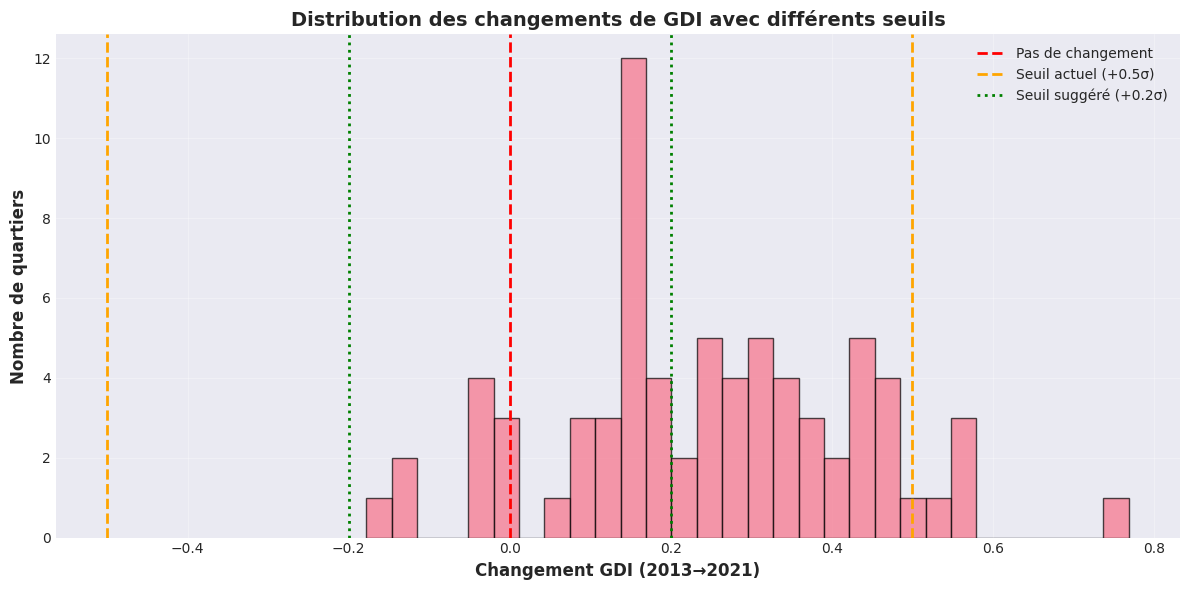

In [85]:
# DIAGNOSTIC: Analyser la distribution des changements de GDI
print("="*60)
print("DIAGNOSTIC: Distribution des changements de GDI")
print("="*60)

print(f"\nStatistiques du delta_total:")
print(f"  Mean:   {temporal_data['delta_total'].mean():.4f}")
print(f"  Median: {temporal_data['delta_total'].median():.4f}")
print(f"  Std:    {temporal_data['delta_total'].std():.4f}")
print(f"  Min:    {temporal_data['delta_total'].min():.4f}")
print(f"  Max:    {temporal_data['delta_total'].max():.4f}")

print(f"\nDistribution des changements:")
print(f"  Positifs (augmentation): {(temporal_data['delta_total'] > 0).sum()} quartiers ({(temporal_data['delta_total'] > 0).sum()/len(temporal_data)*100:.1f}%)")
print(f"  Négatifs (diminution):   {(temporal_data['delta_total'] < 0).sum()} quartiers ({(temporal_data['delta_total'] < 0).sum()/len(temporal_data)*100:.1f}%)")
print(f"  Nuls (aucun changement): {(temporal_data['delta_total'] == 0).sum()} quartiers")

print(f"\nTest de différents seuils:")
for test_threshold in [0.1, 0.2, 0.3, 0.4, 0.5]:
    significant = (temporal_data['delta_total'].abs() > test_threshold).sum()
    print(f"  Seuil {test_threshold:.1f}σ: {significant} quartiers avec changement significatif ({significant/len(temporal_data)*100:.1f}%)")

# Visualiser la distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
temporal_data['delta_total'].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Pas de changement')
ax.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Seuil actuel (+0.5σ)')
ax.axvline(-0.5, color='orange', linestyle='--', linewidth=2)
ax.axvline(0.2, color='green', linestyle=':', linewidth=2, label='Seuil suggéré (+0.2σ)')
ax.axvline(-0.2, color='green', linestyle=':', linewidth=2)
ax.set_xlabel('Changement GDI (2013→2021)', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre de quartiers', fontsize=12, fontweight='bold')
ax.set_title('Distribution des changements de GDI avec différents seuils', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Visualizations

### 8.1 GDI Distribution Evolution

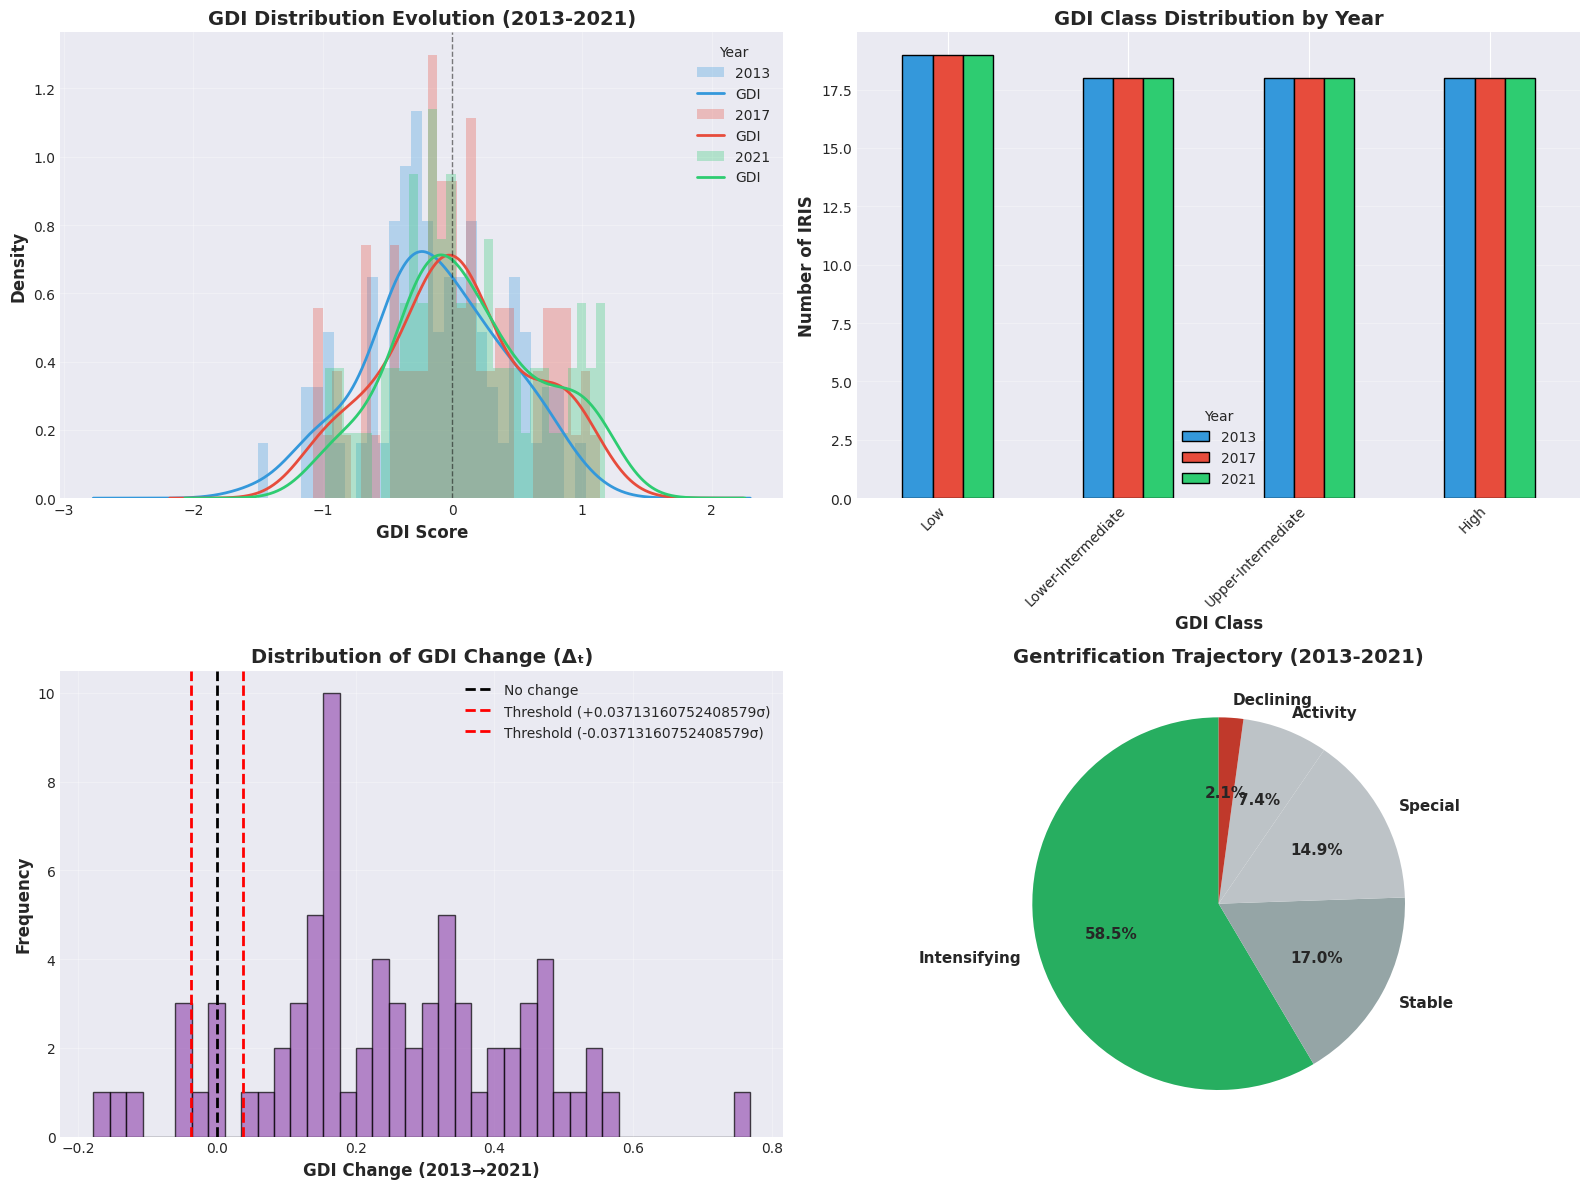

✓ Figure saved: outputs/figures_gdi/gdi_evolution_overview.png


In [86]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: GDI distributions by year (KDE + histogram)
ax = axes[0, 0]
for year, data, color in [(2013, data_2013_class, '#3498db'), 
                           (2017, data_2017_class, '#e74c3c'), 
                           (2021, data_2021_class, '#2ecc71')]:
    data['GDI'].hist(bins=30, alpha=0.3, color=color, ax=ax, density=True, label=str(year))
    data['GDI'].plot(kind='kde', ax=ax, color=color, linewidth=2)

ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('GDI Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('GDI Distribution Evolution (2013-2021)', fontsize=14, fontweight='bold')
ax.legend(title='Year', fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Class composition by year
ax = axes[0, 1]
class_evolution = pd.DataFrame({
    '2013': data_2013_class['GDI_class'].value_counts().sort_index(),
    '2017': data_2017_class['GDI_class'].value_counts().sort_index(),
    '2021': data_2021_class['GDI_class'].value_counts().sort_index()
})
class_evolution.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_xlabel('GDI Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of IRIS', fontsize=12, fontweight='bold')
ax.set_title('GDI Class Distribution by Year', fontsize=14, fontweight='bold')
ax.legend(title='Year', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Plot 3: GDI change distribution
ax = axes[1, 0]
temporal_data['delta_total'].hist(bins=40, ax=ax, color='#9b59b6', edgecolor='black', alpha=0.7)
ax.axvline(0, color='black', linestyle='--', linewidth=2, label='No change')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (+{threshold}σ)')
ax.axvline(-threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (-{threshold}σ)')
ax.set_xlabel('GDI Change (2013→2021)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of GDI Change (Δₜ)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 4: Trajectory pie chart
ax = axes[1, 1]
traj_counts = temporal_data['trajectory'].value_counts()
colors = {'Intensifying': '#27ae60', 'Stable': '#95a5a6', 'Declining': '#c0392b'}
wedges, texts, autotexts = ax.pie(
    traj_counts.values,
    labels=traj_counts.index,
    autopct='%1.1f%%',
    colors=[colors.get(t, '#bdc3c7') for t in traj_counts.index],
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)
ax.set_title('Gentrification Trajectory (2013-2021)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'gdi_evolution_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: {FIGURES_DIR / 'gdi_evolution_overview.png'}")

### 8.2 Spatial Maps of GDI

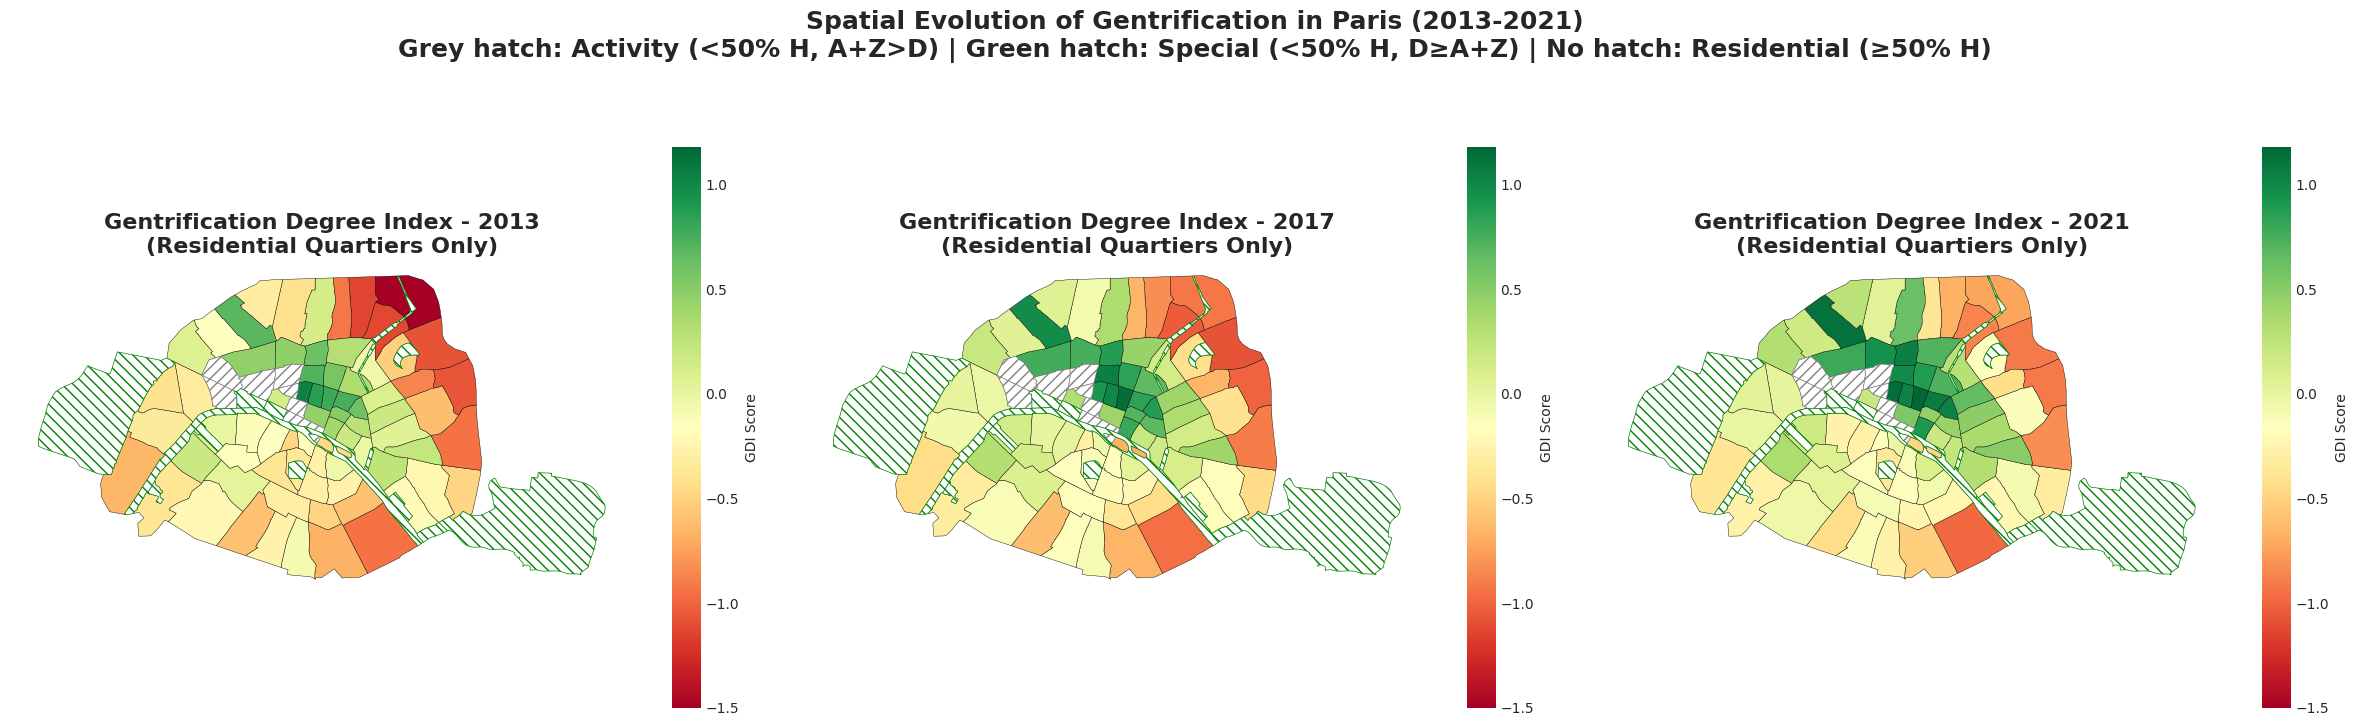

✓ Map saved: outputs/maps_gdi/gdi_spatial_evolution.png


In [87]:
# Convert to GeoDataFrame for mapping
temporal_gdf = gpd.GeoDataFrame(temporal_data, geometry='geometry', crs='EPSG:4326')

# Create 3-panel map: 2013, 2017, 2021 with hatching
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

vmin = temporal_gdf[['GDI_2013', 'GDI_2017', 'GDI_2021']].min().min()
vmax = temporal_gdf[['GDI_2013', 'GDI_2017', 'GDI_2021']].max().max()

for idx, (year, gdi_col, ax) in enumerate([
    (2013, 'GDI_2013', axes[0]),
    (2017, 'GDI_2017', axes[1]),
    (2021, 'GDI_2021', axes[2])
]):
    # Plot only Residential quartiers with GDI colors
    residential = temporal_gdf[temporal_gdf['hatch_type'].isna()]
    residential.plot(
        column=gdi_col,
        ax=ax,
        cmap='RdYlGn',
        legend=True,
        vmin=vmin,
        vmax=vmax,
        edgecolor='black',
        linewidth=0.3,
        legend_kwds={'label': 'GDI Score', 'shrink': 0.8}
    )
    
    # Add hatched quartiers with WHITE background and hatching
    # Grey hatched for Activity quartiers (<50% H, A+Z > D)
    grey_hatch = temporal_gdf[temporal_gdf['hatch_type'] == 'grey']
    if len(grey_hatch) > 0:
        grey_hatch.plot(ax=ax, facecolor='white', edgecolor='grey', 
                        hatch='///', linewidth=0.5, alpha=1.0)
    
    # Green hatched for Special quartiers (<50% H, D ≥ A+Z)
    green_hatch = temporal_gdf[temporal_gdf['hatch_type'] == 'green']
    if len(green_hatch) > 0:
        green_hatch.plot(ax=ax, facecolor='white', edgecolor='green', 
                         hatch='\\\\\\', linewidth=0.5, alpha=1.0)
    
    ax.set_title(f'Gentrification Degree Index - {year}\n(Residential Quartiers Only)', 
                 fontsize=16, fontweight='bold')
    ax.axis('off')

plt.suptitle('Spatial Evolution of Gentrification in Paris (2013-2021)\nGrey hatch: Activity (<50% H, A+Z>D) | Green hatch: Special (<50% H, D≥A+Z) | No hatch: Residential (≥50% H)', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(MAPS_DIR / 'gdi_spatial_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Map saved: {MAPS_DIR / 'gdi_spatial_evolution.png'}")

### 8.3 Trajectory Map

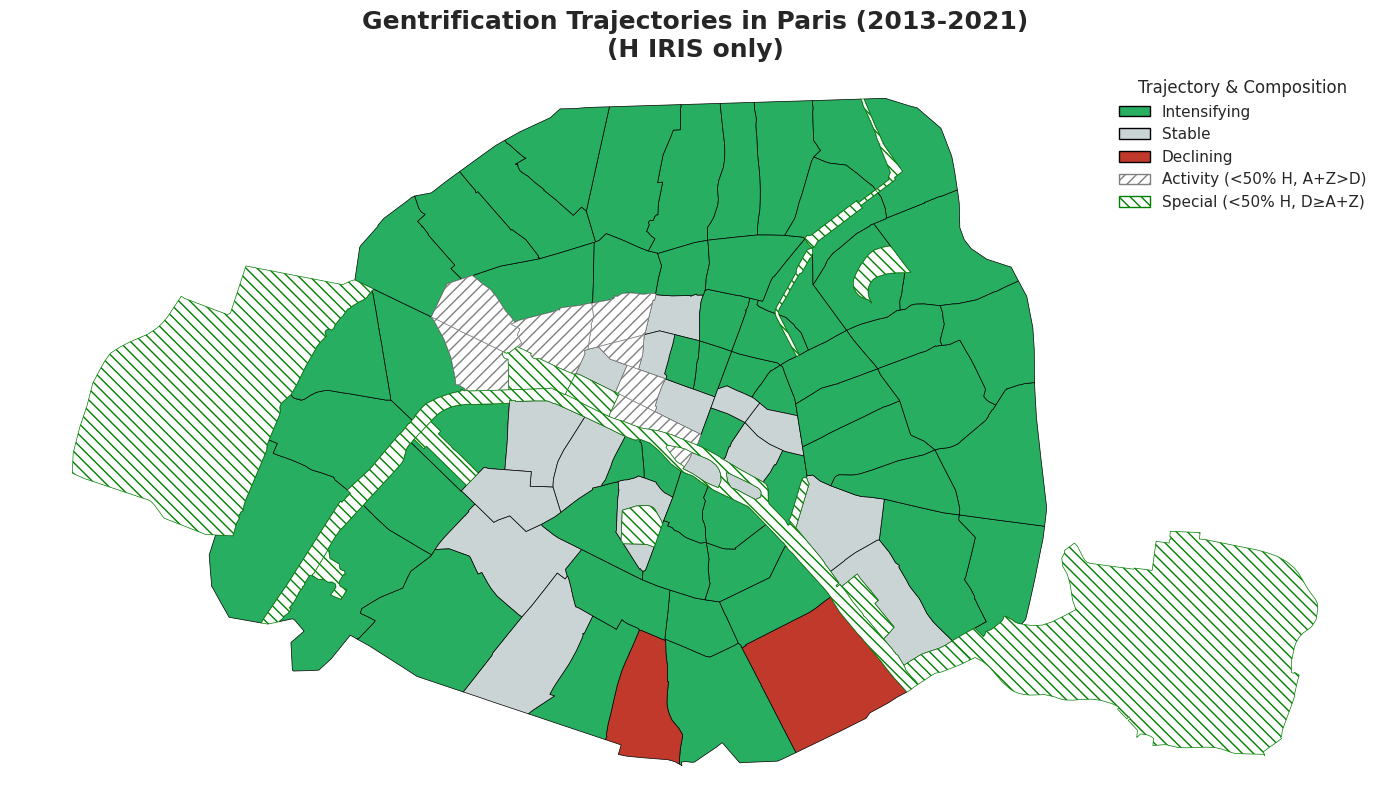

✓ Map saved: outputs/maps_gdi/gdi_trajectories_map.png


In [88]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Color scheme for trajectories and non-residential quartiers
color_map = {
    'Intensifying': '#27ae60',
    'Stable': "#cbd4d5",
    'Declining': '#c0392b',
    'Activity': '#d3d3d3',  # Non-residential, will also have grey hatching
    'Special': '#90ee90'   # Non-residential, will also have green hatching
}

temporal_gdf['color'] = temporal_gdf['trajectory'].map(color_map)

# Plot only Residential quartiers with trajectory colors
residential = temporal_gdf[temporal_gdf['hatch_type'].isna()]
residential.plot(
    ax=ax,
    color=residential['color'],
    edgecolor='black',
    linewidth=0.5
)

# Add hatched quartiers with WHITE background and hatching
# Grey hatched for Activity quartiers (<50% H, A+Z > D)
grey_hatch = temporal_gdf[temporal_gdf['hatch_type'] == 'grey']
if len(grey_hatch) > 0:
    grey_hatch.plot(ax=ax, facecolor='white', edgecolor='grey', 
                    hatch='///', linewidth=0.5, alpha=1.0)

# Green hatched for Special quartiers (<50% H, D ≥ A+Z)
green_hatch = temporal_gdf[temporal_gdf['hatch_type'] == 'green']
if len(green_hatch) > 0:
    green_hatch.plot(ax=ax, facecolor='white', edgecolor='green', 
                     hatch='\\\\\\', linewidth=0.5, alpha=1.0)

# Create legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor='black', label=traj) 
                   for traj, color in color_map.items() if traj in ['Intensifying', 'Stable', 'Declining']]

# Add quartier type labels with white background
legend_elements.append(Patch(facecolor='white', edgecolor='grey', hatch='///', 
                             label='Activity (<50% H, A+Z>D)'))
legend_elements.append(Patch(facecolor='white', edgecolor='green', hatch='\\\\\\', 
                             label='Special (<50% H, D≥A+Z)'))

ax.legend(handles=legend_elements, loc='upper right', fontsize=11, 
          title='Trajectory & Composition', title_fontsize=12)

ax.set_title('Gentrification Trajectories in Paris (2013-2021)\n(H IRIS only)', 
             fontsize=18, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(MAPS_DIR / 'gdi_trajectories_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Map saved: {MAPS_DIR / 'gdi_trajectories_map.png'}")

## 6. Income Classification: Upper, Middle, and Lower Quartiers

This section classifies residential quartiers into three income categories based on median income (median_uc) using tertile splits. This provides a complementary view to the GDI analysis, focusing specifically on income stratification.

In [89]:
# Calculate income tertiles for residential quartiers at each time point
# Using median income (median_uc) as the classification variable

def classify_income_category(median_income, tertiles):
    """
    Classify quartier into income category based on tertile thresholds.
    
    Parameters:
    - median_income: median income value
    - tertiles: array with [33rd percentile, 66th percentile]
    
    Returns:
    - 'Upper': above 66th percentile
    - 'Middle': between 33rd and 66th percentile  
    - 'Lower': below 33rd percentile
    """
    if pd.isna(median_income):
        return None
    if median_income >= tertiles[1]:
        return 'Upper'
    elif median_income >= tertiles[0]:
        return 'Middle'
    else:
        return 'Lower'

# Process each year
income_categories = {}

for year in [2013, 2017, 2021]:
    print(f"\n{'='*60}")
    print(f"Income Classification - {year}")
    print('='*60)
    
    # Get filosofi data for this year
    filosofi_data = eval(f'filosofi_{year}_q')
    
    # Merge with quartier composition to filter residential only
    merged = iris_quartiers.merge(
        filosofi_data[['quartier_iris', 'median_uc']], 
        on='quartier_iris', 
        how='left'
    )
    
    # Filter to residential quartiers only (for income classification)
    residential_only = merged[merged['quartier_label'] == 'Residential'].copy()
    
    # Calculate tertiles (33rd and 66th percentiles) for residential quartiers
    tertiles = residential_only['median_uc'].quantile([0.333, 0.667]).values
    
    print(f"\nIncome Tertiles (€/year):")
    print(f"  Lower/Middle threshold (33rd percentile): €{tertiles[0]:,.0f}")
    print(f"  Middle/Upper threshold (66th percentile): €{tertiles[1]:,.0f}")
    
    # Classify residential quartiers
    residential_only['income_category'] = residential_only['median_uc'].apply(
        lambda x: classify_income_category(x, tertiles)
    )
    
    # Count distribution
    category_counts = residential_only['income_category'].value_counts()
    print(f"\nIncome Category Distribution (Residential quartiers only):")
    for cat in ['Lower', 'Middle', 'Upper']:
        count = category_counts.get(cat, 0)
        pct = (count / len(residential_only)) * 100
        median_val = residential_only[residential_only['income_category'] == cat]['median_uc'].median()
        print(f"  {cat}: {count} quartiers ({pct:.1f}%) - median €{median_val:,.0f}/year")
    
    # Add to full dataset (including non-residential with NaN for income_category)
    merged['income_category'] = merged.apply(
        lambda row: classify_income_category(row['median_uc'], tertiles) 
        if row['quartier_label'] == 'Residential' else None,
        axis=1
    )
    
    # Add hatch_type for Activity and Special quartiers (same logic as before)
    merged['hatch_type'] = merged['quartier_label'].apply(
        lambda x: 'Activity' if x == 'Activity' else ('Special' if x == 'Special' else None)
    )
    
    # Store for mapping
    income_categories[year] = merged[['quartier_iris', 'income_category', 'median_uc', 
                                       'quartier_label', 'hatch_type', 'geometry']].copy()

print("\n" + "="*60)
print("✓ Income classification complete for all years")
print("="*60)


Income Classification - 2013

Income Tertiles (€/year):
  Lower/Middle threshold (33rd percentile): €26,631
  Middle/Upper threshold (66th percentile): €33,005

Income Category Distribution (Residential quartiers only):
  Lower: 24 quartiers (32.9%) - median €23,961/year
  Middle: 25 quartiers (34.2%) - median €30,040/year
  Upper: 24 quartiers (32.9%) - median €37,877/year

Income Classification - 2017

Income Tertiles (€/year):
  Lower/Middle threshold (33rd percentile): €28,855
  Middle/Upper threshold (66th percentile): €34,500

Income Category Distribution (Residential quartiers only):
  Lower: 24 quartiers (32.9%) - median €25,630/year
  Middle: 25 quartiers (34.2%) - median €31,000/year
  Upper: 24 quartiers (32.9%) - median €38,802/year

Income Classification - 2021

Income Tertiles (€/year):
  Lower/Middle threshold (33rd percentile): €31,227
  Middle/Upper threshold (66th percentile): €36,739

Income Category Distribution (Residential quartiers only):
  Lower: 24 quartiers (

### 6.1 Spatial Evolution of Income Categories (2013-2021)

✓ Map saved: outputs/maps_gdi/income_categories_evolution.png


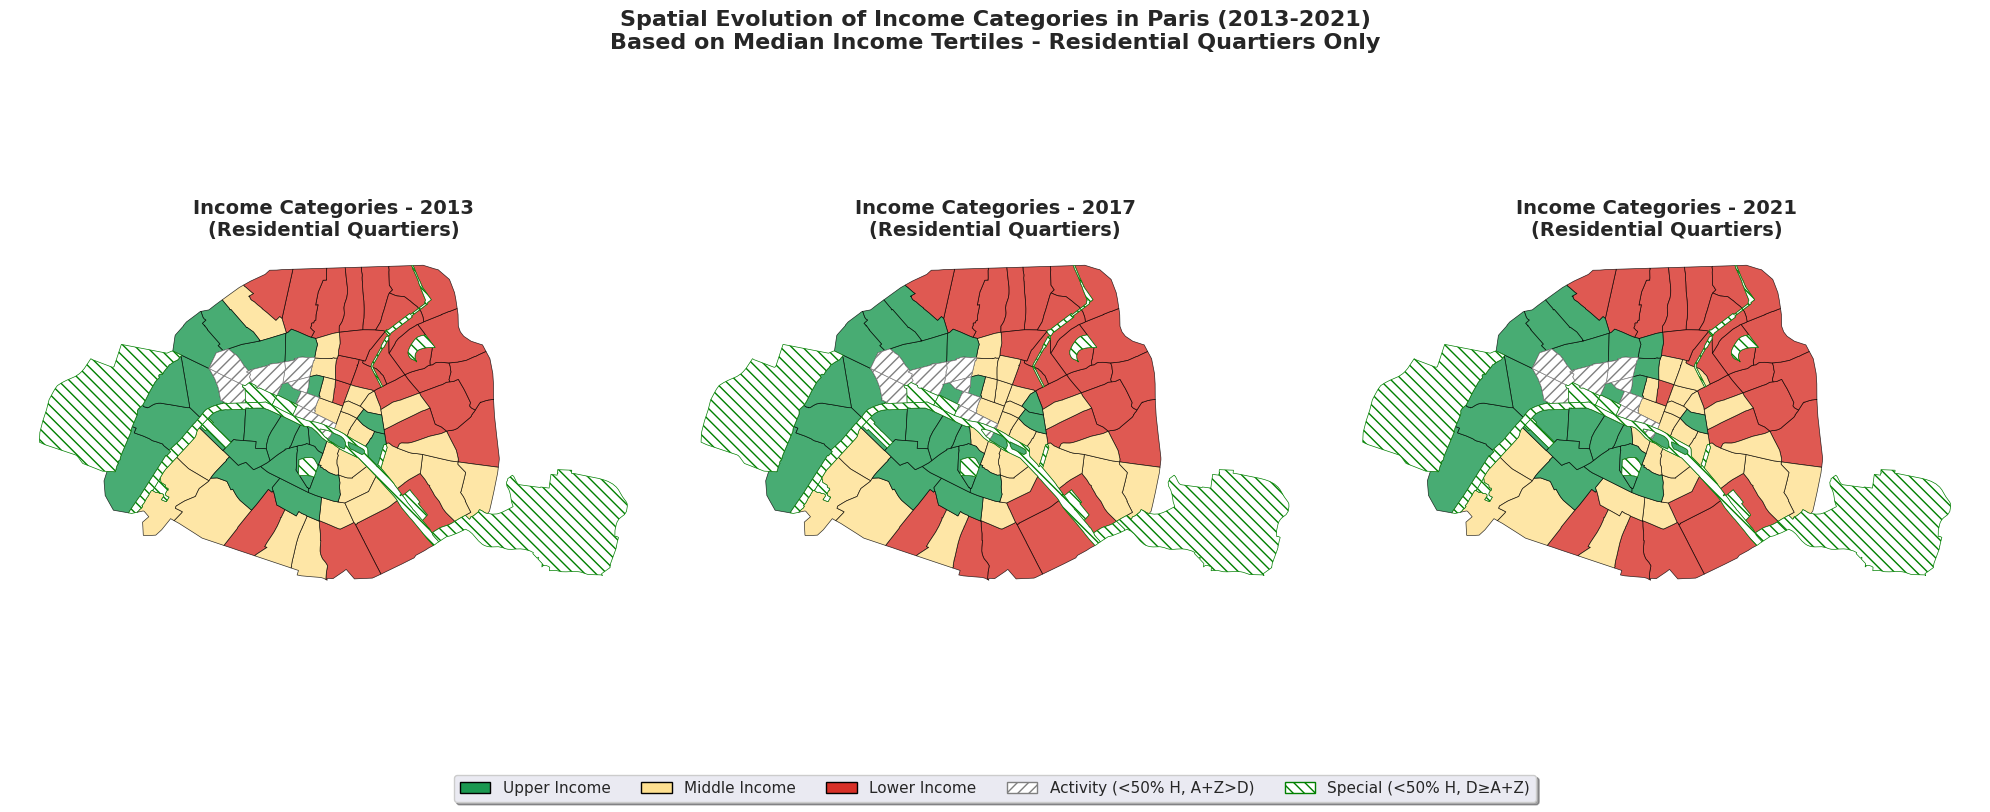

In [90]:
# Create 3-panel map showing income category evolution
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Define color scheme for income categories
income_colors = {
    'Lower': '#d73027',   # Red
    'Middle': '#fee090',  # Light yellow
    'Upper': '#1a9850'    # Green
}

for idx, year in enumerate([2013, 2017, 2021]):
    ax = axes[idx]
    
    # Get data for this year
    data = income_categories[year]
    
    # Plot residential quartiers with income categories
    residential = data[data['income_category'].notna()]
    for category in ['Lower', 'Middle', 'Upper']:
        subset = residential[residential['income_category'] == category]
        if len(subset) > 0:
            subset.plot(
                ax=ax,
                color=income_colors[category],
                edgecolor='black',
                linewidth=0.5,
                label=category,
                alpha=0.8
            )
    
    # Overlay hatched areas (Activity and Special quartiers)
    grey_hatch = data[data['hatch_type'] == 'Activity']
    green_hatch = data[data['hatch_type'] == 'Special']
    
    if len(grey_hatch) > 0:
        grey_hatch.plot(
            ax=ax,
            facecolor='white',
            edgecolor='grey',
            linewidth=0.5,
            hatch='///',
            alpha=1.0
        )
    
    if len(green_hatch) > 0:
        green_hatch.plot(
            ax=ax,
            facecolor='white',
            edgecolor='green',
            linewidth=0.5,
            hatch='\\\\\\',
            alpha=1.0
        )
    
    # Formatting
    ax.set_title(f'Income Categories - {year}\n(Residential Quartiers)', 
                 fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

# Add legend outside the plots (below the figure)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=income_colors['Upper'], edgecolor='black', label='Upper Income'),
    Patch(facecolor=income_colors['Middle'], edgecolor='black', label='Middle Income'),
    Patch(facecolor=income_colors['Lower'], edgecolor='black', label='Lower Income'),
    Patch(facecolor='white', edgecolor='grey', hatch='///', label='Activity (<50% H, A+Z>D)'),
    Patch(facecolor='white', edgecolor='green', hatch='\\\\\\', label='Special (<50% H, D≥A+Z)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=11, 
           frameon=True, fancybox=True, shadow=True, bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Spatial Evolution of Income Categories in Paris (2013-2021)\n' + 
             'Based on Median Income Tertiles - Residential Quartiers Only',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

# Save figure
output_path = MAPS_DIR / 'income_categories_evolution.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Map saved: {output_path}")

plt.show()

### 6.2 Income Category Transitions (2013→2021)

In [91]:
# Analyze income category transitions between 2013 and 2021
# Only for residential quartiers

# Merge 2013 and 2021 income categories
transitions = income_categories[2013][['quartier_iris', 'income_category', 'quartier_label']].copy()
transitions.columns = ['quartier_iris', 'income_2013', 'quartier_label']

transitions = transitions.merge(
    income_categories[2021][['quartier_iris', 'income_category']],
    on='quartier_iris',
    how='left'
)
transitions.columns = ['quartier_iris', 'income_2013', 'quartier_label', 'income_2021']

# Filter to residential quartiers only
residential_transitions = transitions[transitions['quartier_label'] == 'Residential'].copy()

# Create transition label
residential_transitions['transition'] = (
    residential_transitions['income_2013'].astype(str) + ' → ' + 
    residential_transitions['income_2021'].astype(str)
)

# Count transitions
print("="*60)
print("Income Category Transitions (2013 → 2021)")
print("Residential Quartiers Only")
print("="*60)

transition_counts = residential_transitions['transition'].value_counts()

# Group by transition type
stable = []
upward = []
downward = []

for trans, count in transition_counts.items():
    if ' → ' not in trans:
        continue
    start, end = trans.split(' → ')
    if start == end:
        stable.append((trans, count))
    elif (start == 'Lower' and end in ['Middle', 'Upper']) or \
         (start == 'Middle' and end == 'Upper'):
        upward.append((trans, count))
    elif (start == 'Upper' and end in ['Middle', 'Lower']) or \
         (start == 'Middle' and end == 'Lower'):
        downward.append((trans, count))

print("\n📊 STABLE (No change):")
for trans, count in sorted(stable, key=lambda x: x[1], reverse=True):
    pct = (count / len(residential_transitions)) * 100
    print(f"  {trans}: {count} quartiers ({pct:.1f}%)")

print("\n📈 UPWARD MOBILITY (Income increase):")
for trans, count in sorted(upward, key=lambda x: x[1], reverse=True):
    pct = (count / len(residential_transitions)) * 100
    print(f"  {trans}: {count} quartiers ({pct:.1f}%)")

print("\n📉 DOWNWARD MOBILITY (Income decrease):")
for trans, count in sorted(downward, key=lambda x: x[1], reverse=True):
    pct = (count / len(residential_transitions)) * 100
    print(f"  {trans}: {count} quartiers ({pct:.1f}%)")

# Summary statistics
stable_count = sum([c for _, c in stable])
upward_count = sum([c for _, c in upward])
downward_count = sum([c for _, c in downward])

print("\n" + "="*60)
print("SUMMARY:")
print(f"  Stable: {stable_count} ({(stable_count/len(residential_transitions)*100):.1f}%)")
print(f"  Upward: {upward_count} ({(upward_count/len(residential_transitions)*100):.1f}%)")
print(f"  Downward: {downward_count} ({(downward_count/len(residential_transitions)*100):.1f}%)")
print("="*60)

Income Category Transitions (2013 → 2021)
Residential Quartiers Only

📊 STABLE (No change):
  Lower → Lower: 22 quartiers (30.1%)
  Upper → Upper: 21 quartiers (28.8%)
  Middle → Middle: 20 quartiers (27.4%)

📈 UPWARD MOBILITY (Income increase):
  Middle → Upper: 3 quartiers (4.1%)
  Lower → Middle: 2 quartiers (2.7%)

📉 DOWNWARD MOBILITY (Income decrease):
  Upper → Middle: 3 quartiers (4.1%)
  Middle → Lower: 2 quartiers (2.7%)

SUMMARY:
  Stable: 63 (86.3%)
  Upward: 5 (6.8%)
  Downward: 5 (6.8%)


In [92]:
# Export income category data for further analysis
for year in [2013, 2017, 2021]:
    output_file = TABLES_DIR / f'income_categories_{year}.csv'
    
    # Prepare export data
    export_data = income_categories[year][
        ['quartier_iris', 'income_category', 'median_uc', 'quartier_label']
    ].copy()
    
    # Save
    export_data.to_csv(output_file, index=False)
    print(f"✓ Saved: {output_file}")

# Export transitions
transitions_file = TABLES_DIR / 'income_category_transitions.csv'
residential_transitions.to_csv(transitions_file, index=False)
print(f"✓ Saved: {transitions_file}")

✓ Saved: outputs/tables_gdi/income_categories_2013.csv
✓ Saved: outputs/tables_gdi/income_categories_2017.csv
✓ Saved: outputs/tables_gdi/income_categories_2021.csv
✓ Saved: outputs/tables_gdi/income_category_transitions.csv


## 9. Export Results

Save GDI scores, classifications, and trajectories for further analysis

In [93]:
# Export individual years (quartier-level data)
for year, data in [(2013, data_2013_class), (2017, data_2017_class), (2021, data_2021_class)]:
    output_cols = ['quartier_iris', 'GDI', 'GDI_class', 
                   'median_uc', 'share_cs3', 'share_cs6', 'share_25_39', 'share_65plus',
                   'share_activity_income', 'share_pensions', 'share_social_benefits']
    
    data[output_cols].to_csv(TABLES_DIR / f'gdi_{year}.csv', index=False)
    print(f"✓ Exported: {TABLES_DIR / f'gdi_{year}.csv'}")

# Export temporal analysis
temporal_output_cols = ['quartier_iris', 
                        'GDI_2013', 'GDI_2017', 'GDI_2021',
                        'class_2013', 'class_2017', 'class_2021',
                        'delta_1', 'delta_2', 'delta_total', 'trajectory']

temporal_data[temporal_output_cols].to_csv(TABLES_DIR / 'gdi_temporal_analysis.csv', index=False)
print(f"✓ Exported: {TABLES_DIR / 'gdi_temporal_analysis.csv'}")

# Export geographic data with GDI for mapping in QGIS/other tools
temporal_gdf.to_file(MAPS_DIR / 'gdi_paris_2013_2021.geojson', driver='GeoJSON')
print(f"✓ Exported: {MAPS_DIR / 'gdi_paris_2013_2021.geojson'}")

print("\n" + "="*60)
print("ALL OUTPUTS EXPORTED SUCCESSFULLY")
print("="*60)

✓ Exported: outputs/tables_gdi/gdi_2013.csv
✓ Exported: outputs/tables_gdi/gdi_2017.csv
✓ Exported: outputs/tables_gdi/gdi_2021.csv
✓ Exported: outputs/tables_gdi/gdi_temporal_analysis.csv
✓ Exported: outputs/maps_gdi/gdi_paris_2013_2021.geojson

ALL OUTPUTS EXPORTED SUCCESSFULLY


## 10. Summary Statistics and Insights

### Key Findings

In [94]:
print("="*80)
print("GENTRIFICATION DEGREE INDEX (GDI) - SUMMARY REPORT")
print("Paris Intra-Muros Quartier IRIS Analysis (2013-2021)")
print("="*80)

print("\n1. TEMPORAL EVOLUTION OF GDI")
print("-" * 60)
for year, data in [(2013, data_2013_class), (2017, data_2017_class), (2021, data_2021_class)]:
    mean_gdi = data['GDI'].mean()
    std_gdi = data['GDI'].std()
    print(f"  {year}: Mean = {mean_gdi:+.3f}, Std = {std_gdi:.3f}")

print("\n2. GENTRIFICATION CLASSES (2021)")
print("-" * 60)
class_2021 = data_2021_class['GDI_class'].value_counts().sort_index()
for cls, count in class_2021.items():
    pct = count / len(data_2021_class) * 100
    print(f"  {cls:25s}: {count:3d} quartiers ({pct:5.1f}%)")

print("\n3. GENTRIFICATION TRAJECTORIES (2013-2021)")
print("-" * 60)
traj_summary = temporal_data.groupby('trajectory').agg({
    'quartier_iris': 'count',
    'delta_total': 'mean',
    'GDI_2013': 'mean',
    'GDI_2021': 'mean'
}).rename(columns={'quartier_iris': 'Count'})

for traj in traj_summary.index:
    row = traj_summary.loc[traj]
    pct = row['Count'] / len(temporal_data) * 100
    print(f"\n  {traj}:")
    print(f"    Quartier count:      {int(row['Count']):3d} ({pct:5.1f}%)")
    print(f"    Mean GDI change:     {row['delta_total']:+.3f}")
    print(f"    Mean GDI 2013:       {row['GDI_2013']:+.3f}")
    print(f"    Mean GDI 2021:       {row['GDI_2021']:+.3f}")

print("\n4. TOP 10 MOST GENTRIFIED QUARTIERS (2021)")
print("-" * 60)
top_10 = data_2021_class.nlargest(10, 'GDI')[['quartier_iris', 'GDI', 'GDI_class']]
for idx, row in top_10.iterrows():
    print(f"  {row['quartier_iris']:40s} GDI={row['GDI']:+.3f} ({row['GDI_class']})")

print("\n5. TOP 10 LEAST GENTRIFIED QUARTIERS (2021)")
print("-" * 60)
bottom_10 = data_2021_class.nsmallest(10, 'GDI')[['quartier_iris', 'GDI', 'GDI_class']]
for idx, row in bottom_10.iterrows():
    print(f"  {row['quartier_iris']:40s} GDI={row['GDI']:+.3f} ({row['GDI_class']})")

print("\n6. TOP 10 INTENSIFYING QUARTIERS (Largest GDI Increase)")
print("-" * 60)
intensifying_top = temporal_data.nlargest(10, 'delta_total')[['quartier_iris', 'delta_total', 'GDI_2013', 'GDI_2021']]
for idx, row in intensifying_top.iterrows():
    print(f"  {row['quartier_iris']:40s} Δ={row['delta_total']:+.3f} ({row['GDI_2013']:+.2f}→{row['GDI_2021']:+.2f})")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)

GENTRIFICATION DEGREE INDEX (GDI) - SUMMARY REPORT
Paris Intra-Muros Quartier IRIS Analysis (2013-2021)

1. TEMPORAL EVOLUTION OF GDI
------------------------------------------------------------
  2013: Mean = -0.136, Std = 0.535
  2017: Mean = +0.029, Std = 0.562
  2021: Mean = +0.107, Std = 0.557

2. GENTRIFICATION CLASSES (2021)
------------------------------------------------------------
  Low                      :  19 quartiers ( 20.2%)
  Lower-Intermediate       :  18 quartiers ( 19.1%)
  Upper-Intermediate       :  18 quartiers ( 19.1%)
  High                     :  18 quartiers ( 19.1%)

3. GENTRIFICATION TRAJECTORIES (2013-2021)
------------------------------------------------------------

  Activity:
    Quartier count:        7 (  7.4%)
    Mean GDI change:     +nan
    Mean GDI 2013:       +nan
    Mean GDI 2021:       +nan

  Declining:
    Quartier count:        2 (  2.1%)
    Mean GDI change:     -0.109
    Mean GDI 2013:       -0.515
    Mean GDI 2021:       -0.624

  

## 11. Academic Interpretation

### Theoretical Implications

The GDI analysis reveals several key patterns consistent with gentrification theory:

1. **Spatial Concentration**: Gentrification is not evenly distributed but concentrated in specific clusters, supporting the "frontier" metaphor (Smith, 1996)

2. **Multi-dimensional Process**: The composite index shows that gentrification operates through multiple channels simultaneously:
   - Economic (income rise)
   - Social (class replacement)
   - Demographic (age shifts)
   - Structural (income source changes)

3. **Temporal Dynamics**: The intensifying/stable/declining classification distinguishes:
   - Active gentrification fronts (intensifying areas)
   - Established elite enclaves (high but stable)
   - Resistant working-class areas (low and stable)

4. **Policy Relevance**: Identification of intensifying areas enables proactive anti-displacement measures

### Limitations

- **Displacement not directly measured**: GDI shows compositional change but cannot distinguish replacement vs. uplift
- **Aggregation effects**: Quartier-level analysis (aggregating multiple IRIS) provides stability but may mask intra-quartier heterogeneity
- **Cultural dimensions**: Index focuses on measurable socio-economic indicators, missing cultural/symbolic aspects
- **Causality**: GDI identifies correlation patterns but doesn't establish causal mechanisms

### Methodological Note: Quartier-Level Analysis

This analysis operates at the **quartier IRIS level** (94 units) rather than individual IRIS (973 units). Benefits:
- **Statistical stability**: Larger sample sizes reduce noise from small-population IRIS
- **Reduced missing data**: Aggregation mitigates INSEE suppression codes
- **Territorial coherence**: Quartiers align with known neighborhood boundaries
- **Policy relevance**: Scale matches typical urban planning interventions

### Future Research Directions

1. Integrate DVF (real estate transaction) data to correlate GDI with property value changes
2. Add SIRENE (business) data to examine commercial gentrification
3. Spatial autocorrelation analysis (Moran's I) to identify gentrification clusters
4. Longitudinal tracking of individual quartier trajectories with qualitative case studies
5. Sub-quartier analysis where data permits to capture intra-neighborhood variations

---

## References

**Methodology adapted from:**
- Glass, R. (1964). *Introduction: Aspects of Change*. London: MacGibbon & Kee.
- Smith, N. (1996). *The New Urban Frontier: Gentrification and the Revanchist City*. New York: Routledge.
- Hamnett, C. (2003). Gentrification and the middle-class remaking of Inner London, 1961–2001. *Urban Studies*, 40(12), 2401–2426.
- Clerval, A. (2013). *Paris sans le peuple: La gentrification de la capitale*. Paris: La Découverte.
- Freeman, L. (2005). Displacement or succession? Residential mobility in gentrifying neighborhoods. *Urban Affairs Review*, 40(4), 463–491.

**Data sources:**
- INSEE FiLoSoFi (Fichier Localisé Social et Fiscal)
- INSEE Census (Recensement de la Population)
- IGN IRIS geographic boundaries

---

**Notebook created**: 2025-10-16  
**Version**: 4.0  
**Author**: Paris Gentrification Research  
**License**: Academic use only